# PyTorch: IBA (Per-Sample Bottleneck)

This notebook shows how to apply the Per-Sample Bottleneck to pretrained ImageNet models. 

Ensure that `./imagenet` points to your copy of the ImageNet dataset. 

You might want to create a symlink:

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/InformationBottleneck')
sys.path.append('/content/drive/MyDrive/MLMI_InfoBottleneck')

Mounted at /content/drive


In [2]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%load_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

try:
    import IBA
except ModuleNotFoundError:
    sys.path.insert(0, '..')
    import IBA
    
from IBA.pytorch import IBA, tensor_to_np_img
from IBA.pytorch_img_iba import Image_IBA
from IBA.utils import plot_saliency_map

env: CUDA_VISIBLE_DEVICES=0


## Loading Data and Model

### Insert the bottleneck into the model

You can experiment with the location of the bottleneck.

In [3]:
prak_dir = '/content/drive/MyDrive/Prak_MLMI'
image_dir = '/content/drive/MyDrive/InformationBottleneck/imgs'
imagenet_dir = '/content/drive/MyDrive/Prak_MLMI/imagenet'

dev = torch.device('cuda:0')
# dev = torch.device('cpu:0')

# select a model to analyse
model = torchvision.models.vgg16(pretrained=True)
# model = torchvision.models.resnet50(pretrained=True)
# model = torchvision.models.inception_v3(pretrained=True)
model.to(dev).eval()

# load the data
if type(model) == torchvision.models.inception.Inception3:
    image_size = 299
else:
    image_size = 224
    
valset = ImageFolder(
    os.path.join(imagenet_dir, 'train'),
    transform=Compose([
        CenterCrop(256), Resize(image_size), ToTensor(), 
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

trainset = ImageFolder(
    os.path.join(imagenet_dir, 'train'),
    transform=Compose([
        CenterCrop(256), Resize(image_size), ToTensor(), 
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

with open(os.path.join(prak_dir, 'imagenet_class_index.json')) as f:
    idx2class = {int(k): v[1] for k, v in json.load(f).items()}

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
img, target = valset[0]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [4]:
if type(model) == torchvision.models.vgg.VGG:
    iba = IBA(model.features[17])
elif type(model) == torchvision.models.resnet.ResNet:
    iba = IBA(model.layer2)
elif type(model) == torchvision.models.inception.Inception3:
    iba = IBA(model.Mixed_5b)

In [5]:
iba.sigma = None
iba.reset_estimate()

## Estimate Mean and Variance

Here, we estimate the mean and variances of the feature map. It is important for measuring the amount of information transmitted.

In [6]:
iba.estimate(model, trainloader, device=dev, n_samples=1000, progbar=True)

In [7]:
neuron = (12, 3, 4)
print("Neuron at position {:} has mean {:.2f} and std {:.2f}".format(
    neuron, iba.estimator.mean()[neuron],  iba.estimator.std()[neuron]))

Neuron at position (12, 3, 4) has mean -9.24 and std 12.53


In [8]:
iba.estimator.n_samples()

1024

# Information bottleneck

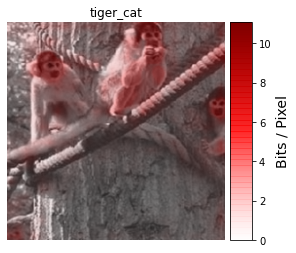

In [9]:
target = 282  # 382: squirrel monkey #677 nail 817 sports car
# preprocess image
img  = Compose([
    Resize((image_size, image_size)), ToTensor(),  
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])(Image.open(os.path.join(image_dir, "monkeys.jpg")))
# whether to use reversed lambda
iba.reverse_lambda = False
iba.beta = 10
model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
ax = plot_saliency_map(heatmap, tensor_to_np_img(img))
_ = ax.set_title(idx2class[target])
plt.show()

Display feature map mask (original size/upscaled to image size)

Text(0.5, 1.0, 'Upscaled Feature Map Mask')

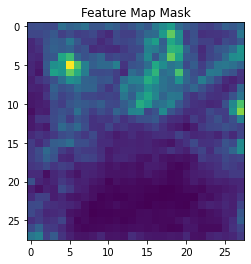

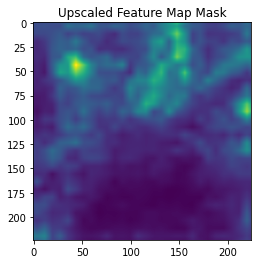

In [12]:
img_tensor_mean = iba.capacity().sum(0)
plt.figure()
plt.imshow(img_tensor_mean.clone().detach().cpu().numpy())
plt.title('Feature Map Mask')
plt.figure()
plt.imshow(heatmap)
plt.title('Upscaled Feature Map Mask')


# GAN
GAN fit the target distribution with generated distribution

In [13]:
from IBA.gan import WGAN_CP

In [14]:
# wgan = WGAN_CP(model, "layer2", 
#                image=img.to(dev), feature_mask=iba.capacity(),
#                feature_noise_mean=iba.estimator.mean(), feature_noise_std=iba.estimator.std(), dev=dev)
wgan = WGAN_CP(model, "features[17]", 
               image=img.to(dev), feature_mask=iba.capacity(), generator_iters=50,
               feature_noise_mean=iba.estimator.mean(), feature_noise_std=iba.estimator.std(), dev=dev)
# wgan = WGAN_CP(model, "Mixed_5b", 
#                image=img.to(dev), feature_mask=iba.capacity(), generator_iters=50,
#                feature_noise_mean=iba.estimator.mean(), feature_noise_std=iba.estimator.std(), dev=dev)

WGAN_CP init model.


In [15]:
wgan.train(dev)

[Epoch 0/50] [Batch 0/25] [D loss: -0.038248] [G loss: 0.003442]
[Epoch 0/50] [Batch 5/25] [D loss: -0.010754] [G loss: 0.006688]
[Epoch 0/50] [Batch 10/25] [D loss: -0.019884] [G loss: 0.011876]
[Epoch 0/50] [Batch 15/25] [D loss: -0.035114] [G loss: 0.020272]
[Epoch 0/50] [Batch 20/25] [D loss: -0.062313] [G loss: 0.035907]
[Epoch 1/50] [Batch 0/25] [D loss: -0.112839] [G loss: 0.064772]
[Epoch 1/50] [Batch 5/25] [D loss: -0.204307] [G loss: 0.117075]
[Epoch 1/50] [Batch 10/25] [D loss: -0.355163] [G loss: 0.201372]
[Epoch 1/50] [Batch 15/25] [D loss: -0.581957] [G loss: 0.324025]
[Epoch 1/50] [Batch 20/25] [D loss: -0.886906] [G loss: 0.486310]
[Epoch 2/50] [Batch 0/25] [D loss: -1.256689] [G loss: 0.675682]
[Epoch 2/50] [Batch 5/25] [D loss: -1.667072] [G loss: 0.882572]
[Epoch 2/50] [Batch 10/25] [D loss: -2.116155] [G loss: 1.103764]
[Epoch 2/50] [Batch 15/25] [D loss: -2.587923] [G loss: 1.339048]
[Epoch 2/50] [Batch 20/25] [D loss: -3.082986] [G loss: 1.577393]
[Epoch 3/50] [Ba

### Display learned image mask

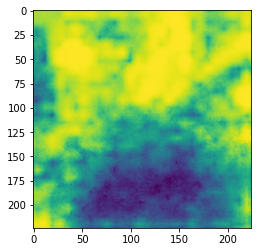

In [16]:
img_tensor = wgan.G.image_mask().clone().detach().cpu().numpy()
# print(wgan.G.mean)
# print(wgan.G.eps)
# print(img_tensor.mean())
img_tensor = img_tensor.mean(0).mean(0)
plt.imshow(img_tensor)

### Learned image mask history during training

In [17]:
for masks in wgan.image_mask_history:
  img_tensor = masks.mean(0).mean(0)
  plt.imshow(img_tensor) 
  plt.figure()
  plt.imshow(img_tensor)
  # print(wgan.D(imgs))

Output hidden; open in https://colab.research.google.com to view.

### Masked feature map from generated data

(10, 512, 28, 28)


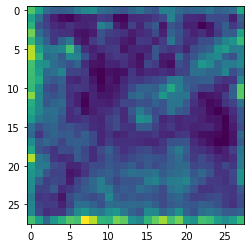

In [18]:
z = torch.zeros_like(wgan.image)
z = z.unsqueeze(0).expand(10, -1, -1, -1).clone().normal_().to(dev)

# Generate a batch of images
fake_imgs = wgan.G(z).clone().detach().cpu().numpy()

print(fake_imgs.shape)
img_tensor = fake_imgs[0].mean(0)
plt.imshow(img_tensor)

### Masked feature map from real data

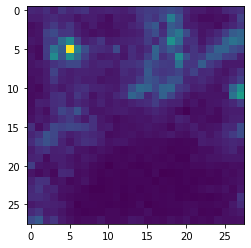

In [19]:
imgs = next(iter(wgan.dataloader))
imgs = imgs[0]
img_tensor = imgs[0].clone().detach().cpu().numpy().mean(0)
plt.imshow(img_tensor)
# print(wgan.D(imgs))

### Discriminator score for generated data

In [20]:
z = torch.zeros_like(wgan.image)
z = z.unsqueeze(0).expand(10, -1, -1, -1).clone().normal_().to(dev)

# Generate a batch of images
fake_imgs = wgan.G(z).clone().detach().cpu().numpy()

print(wgan.D(wgan.G(z)))

tensor([[-10.8947],
        [-10.9014],
        [-10.8790],
        [-10.8675],
        [-10.9017],
        [-10.8826],
        [-10.9236],
        [-10.8680],
        [-10.8637],
        [-10.9235]], device='cuda:0', grad_fn=<AddmmBackward>)


# Image level information bottleneck

In [21]:
image =  img.to(dev)
image_mask = wgan.G.image_mask().clone().detach().to(dev)
img_noise_std = wgan.G.eps
img_moise_mean = wgan.G.mean
img_iba = Image_IBA(image=image, 
                    image_mask=image_mask, 
                    img_eps_std=img_noise_std, 
                    img_eps_mean=img_moise_mean)

### Image level mask with high resulution

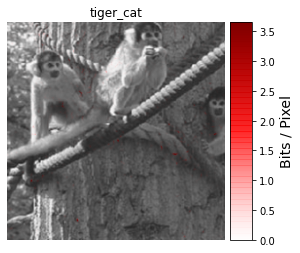

In [22]:
img_iba.to(dev)
img_iba.reverse_lambda = False
img_iba.beta = 20
img_iba.optimization_steps = 50

model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
heatmap = img_iba.analyze(img[None].to(dev), model_loss_closure) 
ax = plot_saliency_map(heatmap, tensor_to_np_img(img))
_ = ax.set_title(idx2class[target])
plt.show()

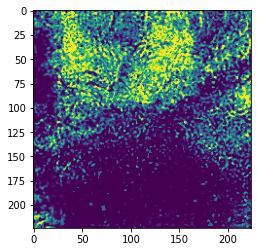

In [23]:
img_tensor = img_iba.sigmoid(img_iba.alpha).detach().cpu().numpy().mean(0).mean(0)
plt.imshow(img_tensor)

### Effect of larger beta

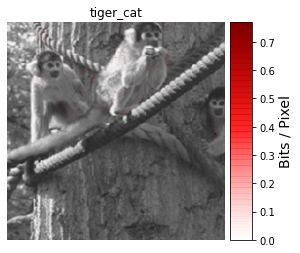

In [28]:
img_iba.to(dev)
img_iba.reverse_lambda = False
img_iba.beta = 70
img_iba.optimization_steps = 50

model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
heatmap = img_iba.analyze(img[None].to(dev), model_loss_closure) 
ax = plot_saliency_map(heatmap, tensor_to_np_img(img))
_ = ax.set_title(idx2class[target])
plt.show()

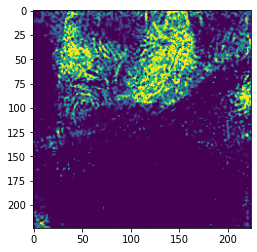

In [29]:
img_tensor = img_iba.sigmoid(img_iba.alpha).detach().cpu().numpy().mean(0).mean(0)
plt.imshow(img_tensor)

### Reverse mask in image IBA

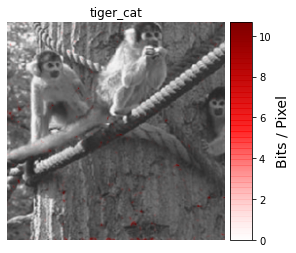

In [30]:
img_iba.to(dev)
img_iba.optimization_steps = 100
img_iba.reverse_lambda = True
img_iba.beta = 70

model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
heatmap = img_iba.analyze(img[None].to(dev), model_loss_closure) 
ax = plot_saliency_map(heatmap, tensor_to_np_img(img))
_ = ax.set_title(idx2class[target])
plt.show()

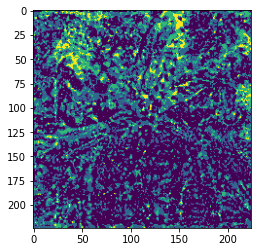

In [31]:
img_tensor = img_iba.sigmoid(img_iba.alpha).detach().cpu().numpy().mean(0).mean(0)
plt.imshow(img_tensor)